In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Dataset

In [3]:
dataset = pd.read_csv('../../../data/pollution.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0


In [4]:
# data.tail(10)

### Dataset Information

In [5]:
print(list(data.columns))

['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']


### Pre-processing

In [6]:
# specify the number of lag hours
n_hours = 24*3
K = 24
n_features = data.shape[1]

#### PM25

In [7]:
# Pre-processing
pms = dataset[['pollution']]
print("pms.shape:", pms.shape)


pms_supervised = series_to_supervised(pms, n_hours, K)
pms_supervised.reset_index(drop=True, inplace=True)
print("pms_supervised.shape:", pms_supervised.shape)

pms.shape: (43800, 1)
pms_supervised.shape: (43705, 96)


In [8]:
# pms_supervised

#### Prior known covariates (9)

In [9]:
prior_known_cov = data[['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']]
print("prior_known_cov.shape:", prior_known_cov.shape)

prior_known_cov_supervised = series_to_supervised(prior_known_cov, n_hours, K)
print("prior_known_cov_supervised.shape:", prior_known_cov_supervised.shape)

prior_known_cov.shape: (43800, 10)
prior_known_cov_supervised.shape: (43705, 960)


In [10]:
prior_known_cov_supervised.reset_index(drop=True, inplace=True)
prior_known_cov_supervised.columns = ['past_known_cov_' + i for i in list(prior_known_cov_supervised.columns)]

In [11]:
prior_known_cov_supervised

,past_known_cov_var1(t-72),past_known_cov_var2(t-72),past_known_cov_var3(t-72),past_known_cov_var4(t-72),past_known_cov_var5(t-72),past_known_cov_var6(t-72),past_known_cov_var7(t-72),past_known_cov_var8(t-72),past_known_cov_var9(t-72),past_known_cov_var10(t-72),...,past_known_cov_var1(t+23),past_known_cov_var2(t+23),past_known_cov_var3(t+23),past_known_cov_var4(t+23),past_known_cov_var5(t+23),past_known_cov_var6(t+23),past_known_cov_var7(t+23),past_known_cov_var8(t+23),past_known_cov_var9(t+23),past_known_cov_var10(t+23)
0,-16.0,-4.0,1020.0,1.79,0.0,0.0,0.0,0.0,1.0,0.0,...,-22.0,-16.0,1033.0,23.70,0.0,0.0,0.0,1.0,0.0,0.0
1,-15.0,-4.0,1020.0,2.68,0.0,0.0,0.0,0.0,1.0,0.0,...,-25.0,-17.0,1033.0,26.83,0.0,0.0,0.0,1.0,0.0,0.0
2,-11.0,-5.0,1021.0,3.57,0.0,0.0,0.0,0.0,1.0,0.0,...,-25.0,-14.0,1033.0,4.02,0.0,0.0,1.0,0.0,0.0,0.0
3,-7.0,-5.0,1022.0,5.36,1.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-14.0,1034.0,8.04,0.0,0.0,1.0,0.0,0.0,0.0
4,-7.0,-5.0,1022.0,6.25,2.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-14.0,1033.0,13.85,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,-9.0,-3.0,1026.0,3.57,0.0,0.0,0.0,0.0,0.0,1.0,...,-23.0,-2.0,1034.0,231.97,0.0,0.0,0.0,1.0,0.0,0.0
43701,-9.0,-4.0,1026.0,4.46,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,237.78,0.0,0.0,0.0,1.0,0.0,0.0
43702,-7.0,-4.0,1025.0,5.35,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,242.70,0.0,0.0,0.0,1.0,0.0,0.0
43703,-9.0,-5.0,1025.0,6.24,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-4.0,1034.0,246.72,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
prior_known_future_cov = prior_known_cov_supervised.iloc[:, n_hours*prior_known_cov.shape[1]:]
prior_known_future_cov

,past_known_cov_var1(t),past_known_cov_var2(t),past_known_cov_var3(t),past_known_cov_var4(t),past_known_cov_var5(t),past_known_cov_var6(t),past_known_cov_var7(t),past_known_cov_var8(t),past_known_cov_var9(t),past_known_cov_var10(t),...,past_known_cov_var1(t+23),past_known_cov_var2(t+23),past_known_cov_var3(t+23),past_known_cov_var4(t+23),past_known_cov_var5(t+23),past_known_cov_var6(t+23),past_known_cov_var7(t+23),past_known_cov_var8(t+23),past_known_cov_var9(t+23),past_known_cov_var10(t+23)
0,-26,-17.0,1035.0,201.58,0,0,0,1,0,0,...,-22.0,-16.0,1033.0,23.70,0.0,0.0,0.0,1.0,0.0,0.0
1,-26,-18.0,1035.0,205.60,0,0,0,1,0,0,...,-25.0,-17.0,1033.0,26.83,0.0,0.0,0.0,1.0,0.0,0.0
2,-26,-19.0,1035.0,208.73,0,0,0,1,0,0,...,-25.0,-14.0,1033.0,4.02,0.0,0.0,1.0,0.0,0.0,0.0
3,-27,-18.0,1035.0,213.65,0,0,0,1,0,0,...,-26.0,-14.0,1034.0,8.04,0.0,0.0,1.0,0.0,0.0,0.0
4,-27,-19.0,1035.0,218.57,0,0,0,1,0,0,...,-26.0,-14.0,1033.0,13.85,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,-11,5.0,1022.0,12.96,0,0,0,1,0,0,...,-23.0,-2.0,1034.0,231.97,0.0,0.0,0.0,1.0,0.0,0.0
43701,-12,4.0,1023.0,21.90,0,0,0,1,0,0,...,-22.0,-3.0,1034.0,237.78,0.0,0.0,0.0,1.0,0.0,0.0
43702,-21,2.0,1025.0,31.73,0,0,0,1,0,0,...,-22.0,-3.0,1034.0,242.70,0.0,0.0,0.0,1.0,0.0,0.0
43703,-22,0.0,1026.0,38.88,0,0,0,1,0,0,...,-22.0,-4.0,1034.0,246.72,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
prior_known_future_cov.shape

(43705, 240)

### N_out, N_in, K

In [14]:
# specify the number of lag hours
n_features = pms.shape[1] + prior_known_cov.shape[1]
n_features

11

### Concatenation

In [15]:
past_prior_known_cov_supervised = prior_known_cov_supervised.iloc[:, :n_hours*prior_known_cov.shape[1]]

In [16]:
columns = []
for i in range(n_hours):
    #columns = columns + past_prior_unknown_cov_supervised.columns[i*prior_unknown_cov.shape[1]:(i+1)*prior_unknown_cov.shape[1]].tolist()
    columns = columns + past_prior_known_cov_supervised.columns[i*prior_known_cov.shape[1]:(i+1)*prior_known_cov.shape[1]].tolist()
# columns

In [17]:
past_unknown_known_cov = concat([
                                #past_prior_unknown_cov_supervised, 
                                past_prior_known_cov_supervised],
                                axis=1)

In [18]:
past_unknown_known_cov

,past_known_cov_var1(t-72),past_known_cov_var2(t-72),past_known_cov_var3(t-72),past_known_cov_var4(t-72),past_known_cov_var5(t-72),past_known_cov_var6(t-72),past_known_cov_var7(t-72),past_known_cov_var8(t-72),past_known_cov_var9(t-72),past_known_cov_var10(t-72),...,past_known_cov_var1(t-1),past_known_cov_var2(t-1),past_known_cov_var3(t-1),past_known_cov_var4(t-1),past_known_cov_var5(t-1),past_known_cov_var6(t-1),past_known_cov_var7(t-1),past_known_cov_var8(t-1),past_known_cov_var9(t-1),past_known_cov_var10(t-1)
0,-16.0,-4.0,1020.0,1.79,0.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-15.0,1035.0,198.45,0.0,0.0,0.0,1.0,0.0,0.0
1,-15.0,-4.0,1020.0,2.68,0.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-17.0,1035.0,201.58,0.0,0.0,0.0,1.0,0.0,0.0
2,-11.0,-5.0,1021.0,3.57,0.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-18.0,1035.0,205.60,0.0,0.0,0.0,1.0,0.0,0.0
3,-7.0,-5.0,1022.0,5.36,1.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-19.0,1035.0,208.73,0.0,0.0,0.0,1.0,0.0,0.0
4,-7.0,-5.0,1022.0,6.25,2.0,0.0,0.0,0.0,1.0,0.0,...,-27.0,-18.0,1035.0,213.65,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,-9.0,-3.0,1026.0,3.57,0.0,0.0,0.0,0.0,0.0,1.0,...,-8.0,6.0,1021.0,5.81,0.0,0.0,0.0,1.0,0.0,0.0
43701,-9.0,-4.0,1026.0,4.46,0.0,0.0,0.0,0.0,0.0,1.0,...,-11.0,5.0,1022.0,12.96,0.0,0.0,0.0,1.0,0.0,0.0
43702,-7.0,-4.0,1025.0,5.35,0.0,0.0,0.0,0.0,0.0,1.0,...,-12.0,4.0,1023.0,21.90,0.0,0.0,0.0,1.0,0.0,0.0
43703,-9.0,-5.0,1025.0,6.24,0.0,0.0,0.0,0.0,0.0,1.0,...,-21.0,2.0,1025.0,31.73,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
# non_stages_supervised.reset_index(drop=True, inplace=True)
# stages_supervised.reset_index(drop=True, inplace=True)

all_data = concat([past_unknown_known_cov, pms_supervised.iloc[:, :]], axis=1)

In [20]:
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (43705, 816)


In [21]:
all_data

,past_known_cov_var1(t-72),past_known_cov_var2(t-72),past_known_cov_var3(t-72),past_known_cov_var4(t-72),past_known_cov_var5(t-72),past_known_cov_var6(t-72),past_known_cov_var7(t-72),past_known_cov_var8(t-72),past_known_cov_var9(t-72),past_known_cov_var10(t-72),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
0,-16.0,-4.0,1020.0,1.79,0.0,0.0,0.0,0.0,1.0,0.0,...,41.0,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0
1,-15.0,-4.0,1020.0,2.68,0.0,0.0,0.0,0.0,1.0,0.0,...,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0
2,-11.0,-5.0,1021.0,3.57,0.0,0.0,0.0,0.0,1.0,0.0,...,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0
3,-7.0,-5.0,1022.0,5.36,1.0,0.0,0.0,0.0,1.0,0.0,...,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0
4,-7.0,-5.0,1022.0,6.25,2.0,0.0,0.0,0.0,1.0,0.0,...,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,-9.0,-3.0,1026.0,3.57,0.0,0.0,0.0,0.0,0.0,1.0,...,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0
43701,-9.0,-4.0,1026.0,4.46,0.0,0.0,0.0,0.0,0.0,1.0,...,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0
43702,-7.0,-4.0,1025.0,5.35,0.0,0.0,0.0,0.0,0.0,1.0,...,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0
43703,-9.0,-5.0,1025.0,6.24,0.0,0.0,0.0,0.0,0.0,1.0,...,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0,8.0


### Train & Test set

In [22]:
all_data = all_data.values
future_covariates = prior_known_future_cov.values

In [23]:
n_train_hours = int(len(data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]    # 0 column is the rainfall to measure heavy/medium/light
test = all_data[n_train_hours:, :]

n_train_hours: 35040


In [24]:
train_future_cov = prior_known_future_cov.iloc[:n_train_hours, :]
test_future_cov = prior_known_future_cov.iloc[n_train_hours:, :] 

In [25]:
test_future_cov.shape

(8665, 240)

### Normalization

In [26]:
n_hours

72

In [27]:
n_features

11

In [28]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (35040, 792) (35040, 24) (8665, 792) (8665, 24)


In [29]:
# normalize features
scaler1 = MinMaxScaler(feature_range=(0, 1))

train_future_cov = scaler1.fit_transform(train_future_cov)
test_future_cov = scaler1.fit_transform(test_future_cov)
print("train_future_cov.shape, test_future_cov.shape:", train_future_cov.shape, test_future_cov.shape)

train_future_cov.shape, test_future_cov.shape: (35040, 240) (8665, 240)


In [30]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (35040, 72, 11) (35040, 24) (8665, 72, 11) (8665, 24)


In [31]:
train_future_cov = train_future_cov.reshape(train_future_cov.shape[0], K, -1)
test_future_cov = test_future_cov.reshape(test_future_cov.shape[0], K, -1)
print("train_future_cov.shape, test_future_cov.shape:", train_future_cov.shape, test_future_cov.shape)

train_future_cov.shape, test_future_cov.shape: (35040, 24, 10) (8665, 24, 10)


In [32]:
train_y = train_y.reshape((train_y.shape[0], K, -1))
test_y = test_y.reshape((test_y.shape[0], K, -1))
print(train_y.shape, test_y.shape)

(35040, 24, 1) (8665, 24, 1)


In [33]:
# past_inputs

### Model

In [50]:
# latent_dim = 128

# Encoding the past
past_inputs = tf.keras.Input(shape=(n_hours, n_features), name='Past_inputs')

# encoder = tf.keras.layers.SimpleRNN(96, activation='relu', return_state=True, return_sequences=False)
encoder = tf.keras.layers.SimpleRNN(96, activation='relu', return_state=True, return_sequences=True, name='Encoder')
encoder_outputs, state_h = encoder(past_inputs)  # state_h, state_c for LSTM


# Adding the future
future_inputs = tf.keras.Input(shape=(K, prior_known_cov.shape[1]), name='Future_inputs')
decoder_lstm = tf.keras.layers.SimpleRNN(96, activation='relu', return_sequences=True, name='Decoder')


# Past + Future
x = decoder_lstm(future_inputs, initial_state=[state_h])   # state_h, state_c


# Output
x = tf.keras.layers.Dense(256, activation='relu', name='Dense_1')(x)
output = tf.keras.layers.Dense(pms.shape[1], name='Dense_2')(x)

# Combining future inputs with recurrent branch output
model = tf.keras.models.Model(inputs=[past_inputs, future_inputs], outputs=output)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Past_inputs (InputLayer)        [(None, 72, 11)]     0                                            
__________________________________________________________________________________________________
Future_inputs (InputLayer)      [(None, 24, 10)]     0                                            
__________________________________________________________________________________________________
Encoder (SimpleRNN)             [(None, 72, 96), (No 10368       Past_inputs[0][0]                
__________________________________________________________________________________________________
Decoder (SimpleRNN)             (None, 24, 96)       10272       Future_inputs[0][0]              
                                                                 Encoder[0][1]              

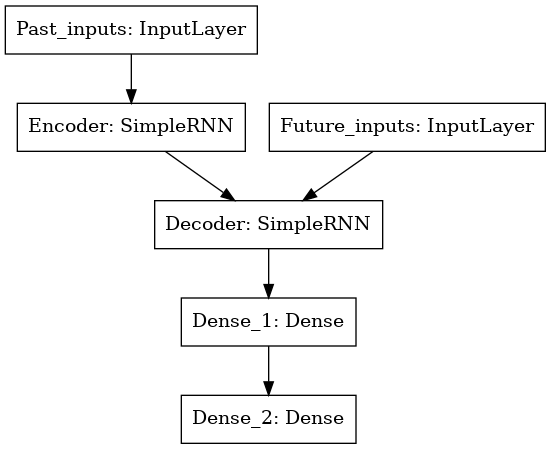

In [51]:
tf.keras.utils.plot_model(
    model,
#     to_file='model_rnn_plot_24.png',
    show_shapes=False,

    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
#     layer_range=None,
#     show_layer_activations=False
)

Epoch 1/1000

Epoch 00001: val_mae improved from inf to 0.11391, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 3s - loss: 0.0161 - mae: 0.0979 - val_loss: 0.0252 - val_mae: 0.1139
Epoch 2/1000

Epoch 00002: val_mae improved from 0.11391 to 0.10007, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 3s - loss: 0.0104 - mae: 0.0772 - val_loss: 0.0210 - val_mae: 0.1001
Epoch 3/1000

Epoch 00003: val_mae improved from 0.10007 to 0.09411, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 3s - loss: 0.0088 - mae: 0.0688 - val_loss: 0.0196 - val_mae: 0.0941
Epoch 4/1000

Epoch 00004: val_mae improved from 0.09411 to 0.09100, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 3s - loss: 0.0080 - mae: 0.0648 - val_loss: 0.0188 - val_mae: 0.0910
Epoch 5/1000

Epoch 00005: val_mae improved from 0.09100 to 0.08920, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 3s - loss: 0.0076 - mae

Epoch 40/1000

Epoch 00040: val_mae improved from 0.06344 to 0.06249, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 3s - loss: 0.0041 - mae: 0.0441 - val_loss: 0.0089 - val_mae: 0.0625
Epoch 41/1000

Epoch 00041: val_mae improved from 0.06249 to 0.06189, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 3s - loss: 0.0040 - mae: 0.0436 - val_loss: 0.0087 - val_mae: 0.0619
Epoch 42/1000

Epoch 00042: val_mae improved from 0.06189 to 0.06153, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 3s - loss: 0.0039 - mae: 0.0432 - val_loss: 0.0085 - val_mae: 0.0615
Epoch 43/1000

Epoch 00043: val_mae improved from 0.06153 to 0.06118, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 3s - loss: 0.0039 - mae: 0.0428 - val_loss: 0.0084 - val_mae: 0.0612
Epoch 44/1000

Epoch 00044: val_mae improved from 0.06118 to 0.06089, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 3s - loss: 0.0

Epoch 83/1000

Epoch 00083: val_mae did not improve from 0.05618
69/69 - 3s - loss: 0.0032 - mae: 0.0377 - val_loss: 0.0073 - val_mae: 0.0567
Epoch 84/1000

Epoch 00084: val_mae improved from 0.05618 to 0.05604, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 3s - loss: 0.0031 - mae: 0.0376 - val_loss: 0.0072 - val_mae: 0.0560
Epoch 85/1000

Epoch 00085: val_mae improved from 0.05604 to 0.05600, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 3s - loss: 0.0031 - mae: 0.0376 - val_loss: 0.0072 - val_mae: 0.0560
Epoch 86/1000

Epoch 00086: val_mae did not improve from 0.05600
69/69 - 3s - loss: 0.0031 - mae: 0.0375 - val_loss: 0.0072 - val_mae: 0.0564
Epoch 87/1000

Epoch 00087: val_mae improved from 0.05600 to 0.05579, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 3s - loss: 0.0031 - mae: 0.0374 - val_loss: 0.0072 - val_mae: 0.0558
Epoch 88/1000

Epoch 00088: val_mae did not improve from 0.05579
69/69 - 3s - loss:

Epoch 130/1000

Epoch 00130: val_mae did not improve from 0.05409
69/69 - 3s - loss: 0.0029 - mae: 0.0356 - val_loss: 0.0069 - val_mae: 0.0541
Epoch 131/1000

Epoch 00131: val_mae improved from 0.05409 to 0.05403, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 3s - loss: 0.0028 - mae: 0.0355 - val_loss: 0.0069 - val_mae: 0.0540
Epoch 132/1000

Epoch 00132: val_mae did not improve from 0.05403
69/69 - 3s - loss: 0.0028 - mae: 0.0355 - val_loss: 0.0069 - val_mae: 0.0544
Epoch 133/1000

Epoch 00133: val_mae did not improve from 0.05403
69/69 - 3s - loss: 0.0028 - mae: 0.0355 - val_loss: 0.0069 - val_mae: 0.0542
Epoch 134/1000

Epoch 00134: val_mae did not improve from 0.05403
69/69 - 3s - loss: 0.0028 - mae: 0.0354 - val_loss: 0.0069 - val_mae: 0.0545
Epoch 135/1000

Epoch 00135: val_mae improved from 0.05403 to 0.05399, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 3s - loss: 0.0028 - mae: 0.0354 - val_loss: 0.0069 - val_mae: 0.0540
Epoc

Epoch 183/1000

Epoch 00183: val_mae did not improve from 0.05306
69/69 - 3s - loss: 0.0027 - mae: 0.0342 - val_loss: 0.0068 - val_mae: 0.0533
Epoch 184/1000

Epoch 00184: val_mae did not improve from 0.05306
69/69 - 3s - loss: 0.0026 - mae: 0.0342 - val_loss: 0.0067 - val_mae: 0.0532
Epoch 185/1000

Epoch 00185: val_mae did not improve from 0.05306
69/69 - 3s - loss: 0.0026 - mae: 0.0342 - val_loss: 0.0067 - val_mae: 0.0533
Epoch 186/1000

Epoch 00186: val_mae improved from 0.05306 to 0.05302, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 3s - loss: 0.0026 - mae: 0.0341 - val_loss: 0.0067 - val_mae: 0.0530
Epoch 187/1000

Epoch 00187: val_mae did not improve from 0.05302
69/69 - 3s - loss: 0.0026 - mae: 0.0341 - val_loss: 0.0068 - val_mae: 0.0532
Epoch 188/1000

Epoch 00188: val_mae improved from 0.05302 to 0.05295, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 3s - loss: 0.0026 - mae: 0.0341 - val_loss: 0.0068 - val_mae: 0.0530
Epoc

Epoch 237/1000

Epoch 00237: val_mae did not improve from 0.05260
69/69 - 3s - loss: 0.0025 - mae: 0.0332 - val_loss: 0.0067 - val_mae: 0.0531
Epoch 238/1000

Epoch 00238: val_mae did not improve from 0.05260
69/69 - 3s - loss: 0.0025 - mae: 0.0332 - val_loss: 0.0067 - val_mae: 0.0530
Epoch 239/1000

Epoch 00239: val_mae improved from 0.05260 to 0.05258, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 3s - loss: 0.0025 - mae: 0.0332 - val_loss: 0.0067 - val_mae: 0.0526
Epoch 240/1000

Epoch 00240: val_mae did not improve from 0.05258
69/69 - 3s - loss: 0.0025 - mae: 0.0332 - val_loss: 0.0067 - val_mae: 0.0527
Epoch 241/1000

Epoch 00241: val_mae did not improve from 0.05258
69/69 - 3s - loss: 0.0025 - mae: 0.0332 - val_loss: 0.0067 - val_mae: 0.0531
Epoch 242/1000

Epoch 00242: val_mae did not improve from 0.05258
69/69 - 3s - loss: 0.0025 - mae: 0.0332 - val_loss: 0.0067 - val_mae: 0.0529
Epoch 243/1000

Epoch 00243: val_mae did not improve from 0.05258
69/69 -

Epoch 292/1000

Epoch 00292: val_mae did not improve from 0.05238
69/69 - 3s - loss: 0.0024 - mae: 0.0325 - val_loss: 0.0066 - val_mae: 0.0525
Epoch 293/1000

Epoch 00293: val_mae did not improve from 0.05238
69/69 - 3s - loss: 0.0024 - mae: 0.0324 - val_loss: 0.0067 - val_mae: 0.0527
Epoch 294/1000

Epoch 00294: val_mae did not improve from 0.05238
69/69 - 3s - loss: 0.0024 - mae: 0.0324 - val_loss: 0.0067 - val_mae: 0.0528
Epoch 295/1000

Epoch 00295: val_mae did not improve from 0.05238
69/69 - 3s - loss: 0.0024 - mae: 0.0324 - val_loss: 0.0067 - val_mae: 0.0524
Epoch 296/1000

Epoch 00296: val_mae did not improve from 0.05238
69/69 - 3s - loss: 0.0024 - mae: 0.0324 - val_loss: 0.0067 - val_mae: 0.0526
Epoch 297/1000

Epoch 00297: val_mae did not improve from 0.05238
69/69 - 3s - loss: 0.0024 - mae: 0.0324 - val_loss: 0.0067 - val_mae: 0.0528
Epoch 298/1000

Epoch 00298: val_mae did not improve from 0.05238
69/69 - 3s - loss: 0.0024 - mae: 0.0324 - val_loss: 0.0067 - val_mae: 0.0525

Epoch 349/1000

Epoch 00349: val_mae did not improve from 0.05231
69/69 - 3s - loss: 0.0023 - mae: 0.0318 - val_loss: 0.0067 - val_mae: 0.0526
Epoch 350/1000

Epoch 00350: val_mae did not improve from 0.05231
69/69 - 3s - loss: 0.0023 - mae: 0.0317 - val_loss: 0.0067 - val_mae: 0.0525
Epoch 351/1000

Epoch 00351: val_mae improved from 0.05231 to 0.05228, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 3s - loss: 0.0023 - mae: 0.0318 - val_loss: 0.0066 - val_mae: 0.0523
Epoch 352/1000

Epoch 00352: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0023 - mae: 0.0318 - val_loss: 0.0067 - val_mae: 0.0527
Epoch 353/1000

Epoch 00353: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0023 - mae: 0.0317 - val_loss: 0.0067 - val_mae: 0.0527
Epoch 354/1000

Epoch 00354: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0023 - mae: 0.0317 - val_loss: 0.0067 - val_mae: 0.0528
Epoch 355/1000

Epoch 00355: val_mae did not improve from 0.05228
69/69 -

Epoch 406/1000

Epoch 00406: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0022 - mae: 0.0312 - val_loss: 0.0067 - val_mae: 0.0526
Epoch 407/1000

Epoch 00407: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0022 - mae: 0.0311 - val_loss: 0.0067 - val_mae: 0.0528
Epoch 408/1000

Epoch 00408: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0022 - mae: 0.0311 - val_loss: 0.0067 - val_mae: 0.0527
Epoch 409/1000

Epoch 00409: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0022 - mae: 0.0311 - val_loss: 0.0067 - val_mae: 0.0524
Epoch 410/1000

Epoch 00410: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0022 - mae: 0.0311 - val_loss: 0.0067 - val_mae: 0.0525
Epoch 411/1000

Epoch 00411: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0022 - mae: 0.0311 - val_loss: 0.0067 - val_mae: 0.0526
Epoch 412/1000

Epoch 00412: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0022 - mae: 0.0311 - val_loss: 0.0067 - val_mae: 0.0528

Epoch 464/1000

Epoch 00464: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0021 - mae: 0.0306 - val_loss: 0.0067 - val_mae: 0.0527
Epoch 465/1000

Epoch 00465: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0021 - mae: 0.0306 - val_loss: 0.0067 - val_mae: 0.0528
Epoch 466/1000

Epoch 00466: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0021 - mae: 0.0306 - val_loss: 0.0068 - val_mae: 0.0532
Epoch 467/1000

Epoch 00467: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0021 - mae: 0.0306 - val_loss: 0.0067 - val_mae: 0.0526
Epoch 468/1000

Epoch 00468: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0021 - mae: 0.0306 - val_loss: 0.0067 - val_mae: 0.0525
Epoch 469/1000

Epoch 00469: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0021 - mae: 0.0306 - val_loss: 0.0067 - val_mae: 0.0528
Epoch 470/1000

Epoch 00470: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0021 - mae: 0.0306 - val_loss: 0.0068 - val_mae: 0.0531

Epoch 522/1000

Epoch 00522: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0020 - mae: 0.0301 - val_loss: 0.0067 - val_mae: 0.0527
Epoch 523/1000

Epoch 00523: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0020 - mae: 0.0301 - val_loss: 0.0068 - val_mae: 0.0528
Epoch 524/1000

Epoch 00524: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0020 - mae: 0.0301 - val_loss: 0.0068 - val_mae: 0.0527
Epoch 525/1000

Epoch 00525: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0020 - mae: 0.0301 - val_loss: 0.0068 - val_mae: 0.0528
Epoch 526/1000

Epoch 00526: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0020 - mae: 0.0301 - val_loss: 0.0068 - val_mae: 0.0526
Epoch 527/1000

Epoch 00527: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0020 - mae: 0.0301 - val_loss: 0.0068 - val_mae: 0.0525
Epoch 528/1000

Epoch 00528: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0020 - mae: 0.0301 - val_loss: 0.0068 - val_mae: 0.0527

Epoch 580/1000

Epoch 00580: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0020 - mae: 0.0297 - val_loss: 0.0068 - val_mae: 0.0532
Epoch 581/1000

Epoch 00581: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0020 - mae: 0.0297 - val_loss: 0.0068 - val_mae: 0.0529
Epoch 582/1000

Epoch 00582: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0020 - mae: 0.0297 - val_loss: 0.0068 - val_mae: 0.0533
Epoch 583/1000

Epoch 00583: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0020 - mae: 0.0296 - val_loss: 0.0068 - val_mae: 0.0530
Epoch 584/1000

Epoch 00584: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0020 - mae: 0.0296 - val_loss: 0.0068 - val_mae: 0.0528
Epoch 585/1000

Epoch 00585: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0020 - mae: 0.0296 - val_loss: 0.0068 - val_mae: 0.0532
Epoch 586/1000

Epoch 00586: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0020 - mae: 0.0296 - val_loss: 0.0068 - val_mae: 0.0527

Epoch 638/1000

Epoch 00638: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0019 - mae: 0.0293 - val_loss: 0.0069 - val_mae: 0.0529
Epoch 639/1000

Epoch 00639: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0019 - mae: 0.0292 - val_loss: 0.0069 - val_mae: 0.0531
Epoch 640/1000

Epoch 00640: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0019 - mae: 0.0292 - val_loss: 0.0069 - val_mae: 0.0531
Epoch 641/1000

Epoch 00641: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0019 - mae: 0.0292 - val_loss: 0.0069 - val_mae: 0.0531
Epoch 642/1000

Epoch 00642: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0019 - mae: 0.0292 - val_loss: 0.0069 - val_mae: 0.0530
Epoch 643/1000

Epoch 00643: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0019 - mae: 0.0292 - val_loss: 0.0069 - val_mae: 0.0531
Epoch 644/1000

Epoch 00644: val_mae did not improve from 0.05228
69/69 - 3s - loss: 0.0019 - mae: 0.0292 - val_loss: 0.0069 - val_mae: 0.0531

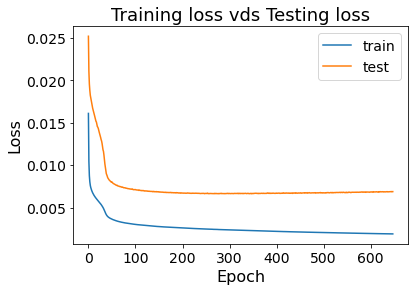

In [38]:
lr = 0.00001
EPOCHS = 1000
model.compile(
              optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])


es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=300)
mc = ModelCheckpoint('saved_model/rnn_encoder_decoder_24h_pm25.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = model.fit(x=[train_X, train_future_cov], y=train_y, 
                    epochs=EPOCHS,
                    verbose=2,
                    validation_data=([test_X, test_future_cov], test_y),
                    batch_size = 512,
                    callbacks=[es, mc]
                   )

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vds Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

In [43]:
from tensorflow.keras.models import load_model

model = load_model('saved_model/rnn_encoder_decoder_24h_pm25.h5')

### Prediction

In [47]:
y_hat = model.predict([test_X, test_future_cov])

In [48]:
print(y_hat.shape)
y_hat = y_hat.reshape((-1, y_hat.shape[1]*y_hat.shape[2]))
print(y_hat.shape)

(8665, 24, 1)
(8665, 24)


In [49]:
print(test_y.shape)
# test_y = test_y.reshape((-1, test_y.shape[1]*test_y.shape[2]))
# print(test_y.shape)

(8665, 24)


In [50]:
inv_yhat = scaler.inverse_transform(y_hat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (8665, 24) (8665, 24)


### Performance

In [51]:
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 35.081
RMSE = 54.685
